In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import entropy, multivariate_normal
from scipy.special import logsumexp
import seaborn as sns
from scipy.stats import norm


# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

### Compression Metric

In [46]:
def compute_compression_metric(gp, X_train):
    """
    Measure of compression: how much the GP smooths/regularizes
    Using effective degrees of freedom or kernel trace
    """
    # Get kernel matrix
    K = gp.kernel_(X_train)
    
    # Effective degrees of freedom (trace of smoother matrix)
    # Higher = less compression, Lower = more compression
    noise_variance = gp.kernel_.k2.noise_level  # WhiteKernel noise

    K_regularized = K + noise_variance * np.eye(len(X_train))
    K_inv = np.linalg.inv(K_regularized)
    effective_dof = np.trace(K @ K_inv)
    
    return effective_dof

### Computing H(Y) 

1. **Gaussian Approximation**:
Approximating Y as a gaussian distribution instead of a mixture of gaussians. This allows us to comput the entropy by just utilizing the varaiance in Y that could be derived by law of total variance. (derived in scribe 4 -- Page 15)

2. **Histogram**:
We bin the sampels in order to make a probabiltiy distribution out of the samples of y_predictions we have. This allows us to remove the assumption of Y being gaussian. This can be noisy with too few samples or too many bins.

3. **KDE**:
We use KDE method to estimate the probability density functoon of Y from samples, without assuming any particular parametric form (i.e. we don't assume its Gaussian). [Most Accurate]

In [47]:
def compute_H_Y_gaussian_approx(y_pred, sigma_pred):
    """
    Approximate H(Y) by treating the marginal as a single Gaussian.
    Uses law of total variance: Var[Y] = E[Var[Y|X]] + Var[E[Y|X]]
    
    Args:
        y_pred: GP mean predictions μ(x) at test points (n,)
        sigma_pred: GP standard deviations σ(x) at test points (n,)
    
    Returns:
        H(Y) approximation
    """
    # Var[Y] = E[σ²(x)] + Var[μ(x)]
    variance_conditional = np.mean(sigma_pred**2)  # E[Var[Y|X]]
    variance_means = np.var(y_pred)                 # Var[E[Y|X]]
    marginal_variance = variance_conditional + variance_means
    
    # H(Y) = 0.5 * log(2πe * Var[Y])
    H_Y = 0.5 * np.log(2 * np.pi * np.e * marginal_variance)
    
    return H_Y, marginal_variance

from scipy.stats import gaussian_kde
def compute_H_Y_kde(y_pred, sigma_pred, n_samples=10000, n_grid=1000):
    """
    Compute H(Y) using Kernel Density Estimation (smoother than histogram).
    
    Args:
        y_pred: GP mean predictions μ(x) at test points (n,)
        sigma_pred: GP standard deviations σ(x) at test points (n,)
        n_samples: Number of samples per test point
        n_grid: Number of points for numerical integration
    
    Returns:
        H(Y) from KDE method
    """
    n = len(y_pred)
    
    # Sample from the mixture
    samples = np.random.normal(y_pred, sigma_pred, size=(n_samples, n))
    all_samples = samples.flatten()
    
    # Fit KDE
    kde = gaussian_kde(all_samples)
    
    # Evaluate on a grid
    y_grid = np.linspace(all_samples.min(), all_samples.max(), n_grid)
    p_y = kde(y_grid)
    
    # Numerical integration: H = -∫ p(y) log p(y) dy
    dy = y_grid[1] - y_grid[0]
    H_Y = -np.sum(p_y * np.log(p_y + 1e-10) * dy)
    
    return H_Y, all_samples, y_grid, p_y

def compute_H_Y_histogram(y_pred, sigma_pred, n_samples=10000, bins=100):
    """
    Compute H(Y) by sampling from the mixture of Gaussians and using histogram.
    
    Args:
        y_pred: GP mean predictions μ(x) at test points (n,)
        sigma_pred: GP standard deviations σ(x) at test points (n,)
        n_samples: Number of samples per test point
        bins: Number of histogram bins
    
    Returns:
        H(Y) from histogram method
    """
    n = len(y_pred)
    
    # Sample from the mixture: for each x_i, sample from N(μ(x_i), σ²(x_i))
    samples = np.random.normal(y_pred, sigma_pred, size=(n_samples, n))
    
    # Flatten to get samples from p(y)
    all_samples = samples.flatten()
    
    # Create histogram (density=True makes it a probability density)
    hist, bin_edges = np.histogram(all_samples, bins=bins, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Remove zero bins (can't take log of 0)
    hist_nonzero = hist[hist > 0]
    
    # Compute entropy: H = -∫ p(y) log p(y) dy ≈ -Σ p_i log(p_i) Δy
    H_Y = -np.sum(hist_nonzero * np.log(hist_nonzero) * bin_width)
    
    return H_Y, all_samples, hist, bin_edges

### Computing H(Y|X)

In [48]:
def compute_predictive_entropy(sigma):
    """
    Compute predictive entropy H(Y|X=x) for each x
    
    For Gaussian: H(Y|X=x) = 0.5 * log(2πe * σ²(x))
    
    Key insight: Entropy depends ONLY on variance σ²(x), NOT on mean μ(x)
    - High var - High entropy - High uncertainty - Low information
    - Low var - Low entropy - Low uncertainty - High information
    
    Returns:
        Pointwise conditional entropy for each x
    """
    return 0.5 * np.log(2 * np.pi * np.e * sigma**2)

def compute_average_conditional_entropy(sigma):
    """
    Compute average conditional entropy H(Y|X) = E_X[H(Y|X=x)]
    
    This measures the expected uncertainty across the input space.
    """
    pointwise_entropy = compute_predictive_entropy(sigma)
    return np.mean(pointwise_entropy)

### Mutual Information Calculation

In [49]:
def compute_information_metrics(gp, X_test):
    """
    Compute information-theoretic quantities for Gaussian Process predictions.
    
    Key quantities:
    - H(Y): Marginal entropy of outputs (total uncertainty)
    - H(Y|X): Conditional entropy (uncertainty given inputs)
    - I(X;Y): Mutual information = H(Y) - H(Y|X)
    
    Interpretation:
    - H(Y|X) = E_x[H(Y|X=x)] = E_x[0.5*log(2πe σ²(x))]
      - Average uncertainty about Y across input space X
      - Only depends on variance σ²(x), NOT on mean μ(x)
    
    - H(Y) : 2 methods to compute
        1. We assume this as a gaussian distribution (which is wrong as in reality it is a mixture of gaussians)
        2. We use histogram

    - I(X;Y) = H(Y) - H(Y|X)
      - How much does knowing X reduce uncertainty about Y?
      - Higher I(X;Y) means X is more informative about Y
    
    Returns dict with all metrics
    """
    y_pred, sigma_pred = gp.predict(X_test, return_std=True)
    
    # H(Y): Marginal entropy (treat predictions as samples from marginal)
    # For Gaussian: H(Y) = 0.5 * log(2πe * marginal_variance)
    # H_Y_gauss, H_Y_hist, H_Y_kde = compare_methods(y_pred, sigma_pred)
    H_Y_gauss, var_gauss = compute_H_Y_gaussian_approx(y_pred, sigma_pred)
    
    # We continue with the gaussian approximation for further calculations
    # H(Y|X): Average conditional entropy
    H_Y_given_X = compute_average_conditional_entropy(sigma_pred)
    
    # I(X;Y): Mutual information = H(Y) - H(Y|X)
    # This measures how much knowing X reduces uncertainty about Y
    I_X_Y = H_Y_gauss - H_Y_given_X
    
    return {
        'H_Y': H_Y_gauss,
        'H_Y_given_X': H_Y_given_X,
        'I_X_Y': I_X_Y,
        'avg_sigma': np.mean(sigma_pred)
    }


### Data Setup

In [50]:
def true_function(x):
    """The true underlying function we want to learn"""
    return np.sin(2 * np.pi * x) + 0.5 * np.sin(4 * np.pi * x)

def generate_data(n_train=20, n_test=100, noise_std=0.1, seed=42):
    """Generate training and test data"""
    np.random.seed(seed)
    
    # Training data
    X_train = np.random.uniform(0, 1, n_train).reshape(-1, 1)
    y_train = true_function(X_train).ravel() + np.random.normal(0, noise_std, n_train)
    
    # Test data (dense grid for visualization)
    X_test = np.linspace(0, 1, n_test).reshape(-1, 1)
    y_test = true_function(X_test).ravel()
    
    return X_train, y_train, X_test, y_test

### Training GPs

In [51]:
def train_gps(X_train, y_train, length_scales):
    """Train GPs with different length scales (compression levels)"""
    gps = {}
    
    for length_scale in length_scales:
        # Kernel: controls how much information is encoded
        # Larger length_scale -> more smoothing -> more compression
        # Fix the length scale to see compression trade-off
        kernel = C(1.0, constant_value_bounds="fixed") * \
                 RBF(length_scale=length_scale, length_scale_bounds="fixed") + \
                 WhiteKernel(noise_level=0.01, noise_level_bounds="fixed")
        
        gp = GaussianProcessRegressor(kernel=kernel, optimizer=None)
        gp.fit(X_train, y_train)
        
        gps[length_scale] = gp
        
        print(f"Length scale {length_scale:.3f}: Kernel = {gp.kernel_}")
    
    return gps

### Plotting and Evaluating Utils

In [52]:

def evaluate_gp(gp, X_test, y_test):
    """Compute various evaluation metrics"""
    y_pred, sigma_pred = gp.predict(X_test, return_std=True)
    
    # Prediction error
    mse = np.mean((y_pred - y_test)**2)
    mae = np.mean(np.abs(y_pred - y_test))
    
    # Negative log-likelihood (information-theoretic loss)
    nll = -np.mean(norm.logpdf(
        y_test, y_pred, scale=sigma_pred
    ))    
    # Predictive entropy (uncertainty)
    pred_entropy = np.mean(compute_predictive_entropy(sigma_pred))
    
    return {
        'mse': mse,
        'mae': mae,
        'nll': nll,
        'pred_entropy': pred_entropy,
        'mean_uncertainty': np.mean(sigma_pred)
    }

def plot_gp_predictions(gps, X_train, y_train, X_test, y_test, length_scales):
    """Plot GP predictions with confidence bands for different length scales"""
    n_models = len(length_scales)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, length_scale in enumerate(length_scales):
        ax = axes[idx]
        gp = gps[length_scale]
        
        # Predictions
        y_pred, sigma_pred = gp.predict(X_test, return_std=True)
        
        # Plot
        ax.plot(X_test, y_test, 'k--', label='True function', linewidth=2, alpha=0.7)
        ax.plot(X_test, y_pred, 'b-', label='GP mean', linewidth=2)
        ax.fill_between(X_test.ravel(), 
                        y_pred - 2*sigma_pred, 
                        y_pred + 2*sigma_pred,
                        alpha=0.3, label='95% confidence')
        ax.scatter(X_train, y_train, c='red', s=50, zorder=10, label='Training data')
        
        # Metrics
        metrics = evaluate_gp(gp, X_test, y_test)
        
        ax.set_title(f'Length Scale = {length_scale:.3f}\n' + 
                    f'MSE = {metrics["mse"]:.4f}, ' +
                    f'Avg Uncertainty = {metrics["mean_uncertainty"]:.4f}',
                    fontsize=12)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_information_tradeoff(gps, X_train, X_test, y_test, length_scales):
    """Plot the information bottleneck trade-off"""
    results = []
    
    for length_scale in length_scales:
        gp = gps[length_scale]
        metrics = evaluate_gp(gp, X_test, y_test)
        
        # Compression metric (lower = more compression)
        compression = compute_compression_metric(gp, X_train)
        
        results.append({
            'length_scale': length_scale,
            'compression': compression,
            'mse': metrics['mse'],
            'nll': metrics['nll'],
            'pred_entropy': metrics['pred_entropy'],
            'mean_uncertainty': metrics['mean_uncertainty']
        })
    
    results = {k: [d[k] for d in results] for k in results[0].keys()}
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Compression vs Prediction Error (IB trade-off)
    ax = axes[0]
    ax.plot(results['compression'], results['mse'], 'o-', linewidth=2, markersize=10)
    for i, ls in enumerate(length_scales):
        ax.annotate(f'ℓ={ls:.2f}', 
                   (results['compression'][i], results['mse'][i]),
                   xytext=(5, 5), textcoords='offset points')
    ax.set_xlabel('Compression (Effective DoF)', fontsize=12)
    ax.set_ylabel('Prediction Error (MSE)', fontsize=12)
    ax.set_title('Information Bottleneck Trade-off\n(Lower left = optimal)', fontsize=13)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Length scale vs NLL
    ax = axes[1]
    ax.plot(results['length_scale'], results['nll'], 'o-', linewidth=2, markersize=10, color='green')
    ax.set_xlabel('Length Scale ℓ', fontsize=12)
    ax.set_ylabel('Negative Log-Likelihood', fontsize=12)
    ax.set_title('Model Fit Quality\n(Lower = better)', fontsize=13)
    ax.set_xscale('log')
    ax.set_xticks(length_scales)  # ← Set x-ticks to actual length scales
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Length scale vs Predictive Entropy
    ax = axes[2]
    ax.plot(results['length_scale'], results['pred_entropy'], 'o-', linewidth=2, markersize=10, color='purple')
    ax.set_xlabel('Length Scale ℓ', fontsize=12)
    ax.set_ylabel('Average Predictive Entropy (H[Y|X])', fontsize=12)
    ax.set_title('Uncertainty Quantification\n(Information content)', fontsize=13)
    ax.set_xscale('log')
    ax.set_xticks(length_scales)  # ← Set x-ticks to actual length scales
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, results

def compare_methods(y_pred, sigma_pred):
    """
    Compare all three methods for computing H(Y)
    """
    print("="*70)
    print("COMPARISON: Computing H(Y) with Different Methods")
    print("="*70)
    
    # Method 1: Gaussian approximation
    H_Y_gauss, var_gauss = compute_H_Y_gaussian_approx(y_pred, sigma_pred)
    print(f"\nMethod 1: Gaussian Approximation")
    print(f"  Marginal variance: {var_gauss:.6f}")
    print(f"  H(Y) = {H_Y_gauss:.6f}")
    
    # Method 2: Histogram
    H_Y_hist, samples_hist, hist, bin_edges = compute_H_Y_histogram(
        y_pred, sigma_pred, n_samples=10000, bins=100
    )
    print(f"\nMethod 2: Histogram (100 bins, 10k samples)")
    print(f"  H(Y) = {H_Y_hist:.6f}")
    print(f"  Total samples: {len(samples_hist):,}")
    
    # Method 3: KDE
    H_Y_kde, samples_kde, y_grid, p_y = compute_H_Y_kde(
        y_pred, sigma_pred, n_samples=10000
    )
    print(f"\nMethod 3: Kernel Density Estimation")
    print(f"  H(Y) = {H_Y_kde:.6f}")
    
    # Differences
    print(f"\n" + "-"*70)
    print(f"Difference (Histogram vs Gaussian):  {H_Y_hist - H_Y_gauss:+.6f}")
    print(f"Difference (KDE vs Gaussian):        {H_Y_kde - H_Y_gauss:+.6f}")
    print(f"Difference (KDE vs Histogram):       {H_Y_kde - H_Y_hist:+.6f}")
    print("="*70)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Histogram
    ax = axes[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, hist, 'b-', linewidth=2, label='Histogram')
    
    # Overlay Gaussian approximation
    from scipy.stats import norm
    mean_gauss = np.mean(y_pred)
    std_gauss = np.sqrt(var_gauss)
    x_range = np.linspace(samples_hist.min(), samples_hist.max(), 500)
    gauss_pdf = norm.pdf(x_range, mean_gauss, std_gauss)
    ax.plot(x_range, gauss_pdf, 'r--', linewidth=2, label='Gaussian approx')
    
    ax.set_xlabel('y', fontsize=12)
    ax.set_ylabel('Density p(y)', fontsize=12)
    ax.set_title(f'Method 1 vs 2\nH(Y) = {H_Y_hist:.4f}', fontsize=13)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: KDE
    ax = axes[1]
    ax.plot(y_grid, p_y, 'g-', linewidth=2, label='KDE')
    ax.plot(x_range, gauss_pdf, 'r--', linewidth=2, label='Gaussian approx')
    ax.set_xlabel('y', fontsize=12)
    ax.set_ylabel('Density p(y)', fontsize=12)
    ax.set_title(f'Method 3: KDE\nH(Y) = {H_Y_kde:.4f}', fontsize=13)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Sample histogram with individual Gaussians
    ax = axes[2]
    ax.hist(samples_hist, bins=50, density=True, alpha=0.5, color='lightblue', label='Samples')
    
    # Plot individual conditional distributions
    x_range_local = np.linspace(samples_hist.min(), samples_hist.max(), 500)
    for i in range(min(10, len(y_pred))):  # Show first 10 only
        component_pdf = norm.pdf(x_range_local, y_pred[i], sigma_pred[i])
        ax.plot(x_range_local, component_pdf / len(y_pred), 
                'k-', alpha=0.3, linewidth=1)
    
    ax.plot(x_range, gauss_pdf, 'r--', linewidth=2, label='Gaussian approx')
    ax.set_xlabel('y', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Mixture Components\n(showing first 10)', fontsize=13)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return H_Y_gauss, H_Y_hist, H_Y_kde

### Main Code

SCRIBE 4: Gaussian Processes and the Information Bottleneck

1. Generating data...
   Training samples: 20
   Test samples: 200

2. Training GPs with different length scales...
Length scale 0.050: Kernel = 1**2 * RBF(length_scale=0.05) + WhiteKernel(noise_level=0.01)
Length scale 0.150: Kernel = 1**2 * RBF(length_scale=0.15) + WhiteKernel(noise_level=0.01)
Length scale 0.350: Kernel = 1**2 * RBF(length_scale=0.35) + WhiteKernel(noise_level=0.01)
Length scale 0.700: Kernel = 1**2 * RBF(length_scale=0.7) + WhiteKernel(noise_level=0.01)

3. Evaluating GPs...

----------------------------------------------------------------------------------------------------
Length     MSE        NLL        H(Y|X)       I(X;Y)       Avg σ     
Scale      (error)    (fit)      (entropy)    (info)       (uncert.) 
----------------------------------------------------------------------------------------------------
0.050      0.0105     -0.49      -0.0976      1.3348       0.2403    
0.150      0.0032     -1.

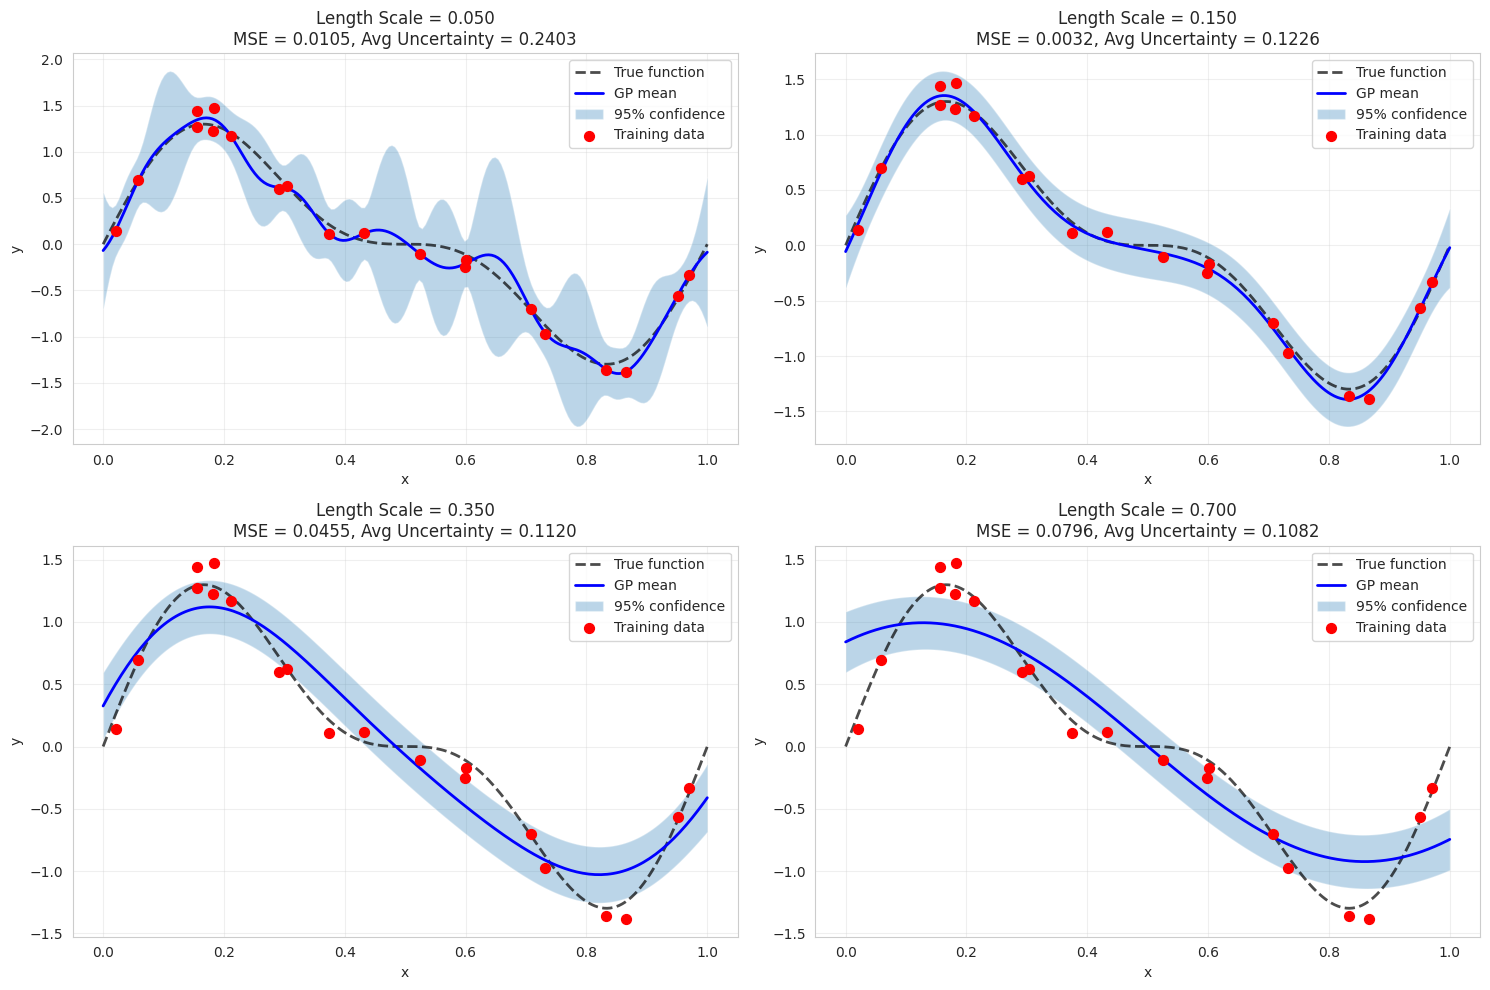

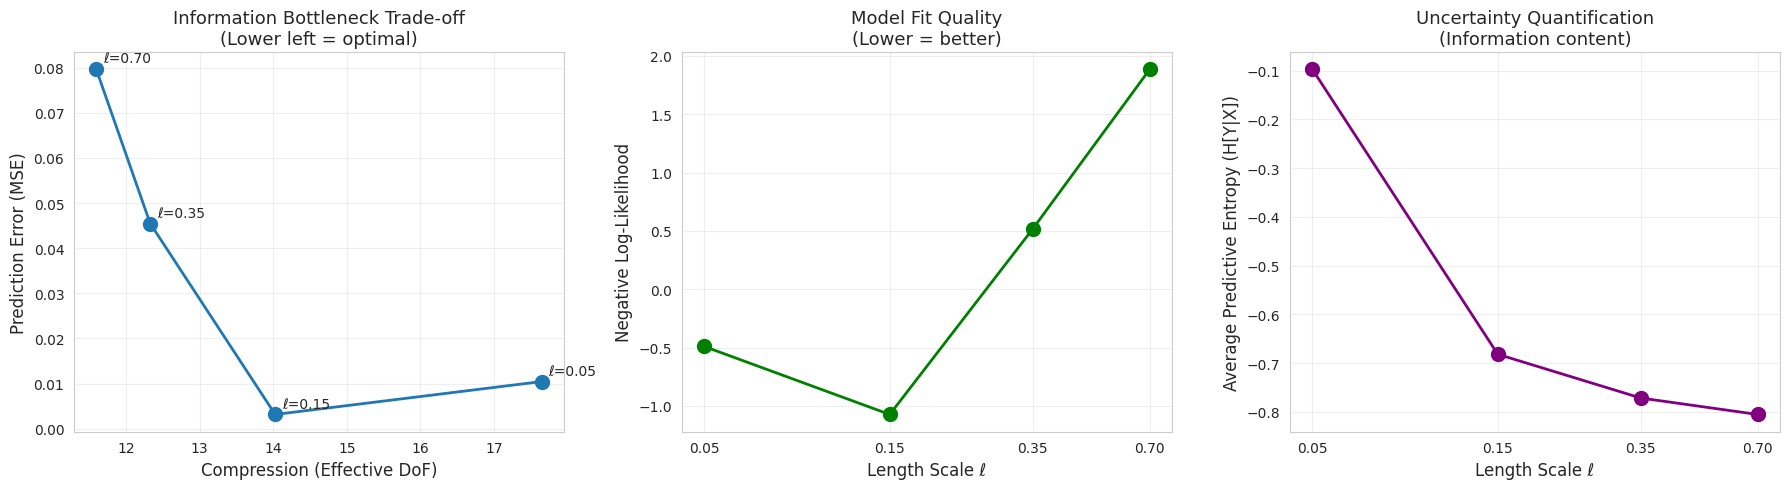

In [53]:
print("=" * 80)
print("SCRIBE 4: Gaussian Processes and the Information Bottleneck")
print("=" * 80)

# Generate data
print("\n1. Generating data...")
X_train, y_train, X_test, y_test = generate_data(n_train=20, n_test=200)
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")

# Different length scales to explore compression
# Small ℓ: less compression (memorizes data, can capture fine details)
# Large ℓ: more compression (over-smooths, loses details)
length_scales = [0.05, 0.15, 0.35, 0.7]

# Train GPs
print("\n2. Training GPs with different length scales...")
gps = train_gps(X_train, y_train, length_scales)

# Evaluate
print("\n3. Evaluating GPs...")
print("\n" + "-" * 100)
print(f"{'Length':<10} {'MSE':<10} {'NLL':<10} {'H(Y|X)':<12} {'I(X;Y)':<12} {'Avg σ':<10}")
print(f"{'Scale':<10} {'(error)':<10} {'(fit)':<10} {'(entropy)':<12} {'(info)':<12} {'(uncert.)':<10}")
print("-" * 100)

for length_scale in length_scales:
    gp = gps[length_scale]
    metrics = evaluate_gp(gp, X_test, y_test)
    info_metrics = compute_information_metrics(gp, X_test)
    
    print(f"{length_scale:<10.3f} {metrics['mse']:<10.4f} {metrics['nll']:<10.2f} "
            f"{info_metrics['H_Y_given_X']:<12.4f} {info_metrics['I_X_Y']:<12.4f} "
            f"{info_metrics['avg_sigma']:<10.4f}")

print("-" * 100)

# Visualize
print("\n4. Creating visualizations...")

fig1 = plot_gp_predictions(gps, X_train, y_train, X_test, y_test, length_scales)
fig2, results = plot_information_tradeoff(gps, X_train, X_test, y_test, length_scales)


# Key insights
print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print("""
1. CONDITIONAL ENTROPY H(Y|X):
    - For Gaussian: H(Y|X=x) = 0.5 * log(2πe σ²(x))
    - Depends ONLY on variance σ²(x), NOT on mean μ(x)
    - Lower H(Y|X) means GP has more information about Y given X

2. MUTUAL INFORMATION I(X;Y) = H(Y) - H(Y|X):
    - Measures how much knowing X reduces uncertainty about Y
    - Larger I(X;Y) means X is more informative about Y
    - Optimal compression maximizes I(X;Y) while minimizing model complexity

3. INFORMATION BOTTLENECK TRADE-OFF:
    - Small ℓ: Retains more information I(X;f) but may overfit
    - Large ℓ: Compresses I(X;f) heavily but may underfit
    - Optimal ℓ balances: min I(X;f) subject to maintaining I(Y;f)

4. UNCERTAINTY QUANTIFICATION:
    - High σ²(x) → High H(Y|X=x) → Low information at x
    - Low σ²(x) → Low H(Y|X=x) → High information at x
    - GP naturally encodes epistemic uncertainty information-theoretically
""")
print("=" * 80)